In [1]:
# torch version = 2.3.1
# torchvision version = 0.18.1
# numpy version = 1.26.4

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# import and normalize data

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are in greyscale
    transforms.Resize((64, 64)),  # Resize images to 48x48 (if not already)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for greyscale
])

train_dataset = torchvision.datasets.ImageFolder(root='./train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./test', transform=transform)



In [3]:
# check data shape
from collections import Counter
# Count the number of samples per class in the training set
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
train_counter = Counter(train_labels)

# Count the number of samples per class in the test set
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
test_counter = Counter(test_labels)

classes = train_dataset.classes

# Print the distribution
print("Training set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {train_counter[i]}')

print("\nTest set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {test_counter[i]}')

Training set class distribution:
anger: 2466
contempt: 165
disgust: 191
fear : 652
happiness: 7528
neutral: 10308
sadness: 3514
surprise: 3562

Test set class distribution:
anger: 644
contempt: 51
disgust: 57
fear : 167
happiness: 1827
neutral: 2597
sadness: 856
surprise: 900


In [4]:
from torch.utils.data import DataLoader, WeightedRandomSampler


# given the the distribution of the train set is not balanced, we will use a weighted sampler
total_samples = len(train_dataset)

# Set random seed for reproducibility
seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


# Calculate class weights based on the training set distribution
class_weights = {class_id: total_samples / count for class_id, count in train_counter.items()}
class_weights_list = [class_weights[label] for label in train_labels]
print(class_weights)
print(len(class_weights_list))

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(class_weights_list, len(class_weights_list), replacement=True, )

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


{0: 11.510948905109489, 1: 172.03636363636363, 2: 148.61780104712042, 3: 43.53680981595092, 4: 3.770722635494155, 5: 2.7537834691501746, 6: 8.077973819009676, 7: 7.969118472768108}
28386


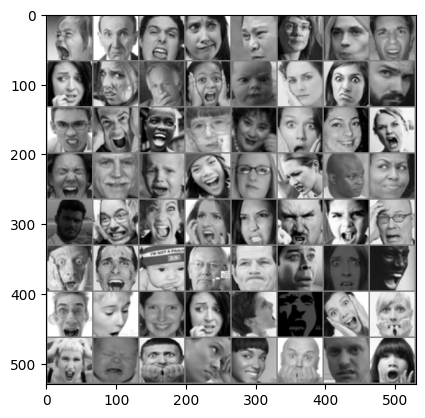

In [25]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images), labels)

In [5]:
# define train and validation as a funcnion

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg = running_loss / len(train_loader)
        train_losses.append(avg)
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():  
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}/{num_epochs}, train Loss: {train_losses[-1]:.4f}, train Acc: {train_accuracies[-1]:.2f}%, validation Loss: {val_losses[-1]:.4f}, validation Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# plot training and validation loss
# Plotting the results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [8]:
# defining training parameters 

# Define loss function and optimizer and other hyper parameters
num_classes = 8 
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
wd = 0.001
num_epochs = 20

In [36]:

# implementing the tiny VGG model
class TinyVGG3(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG3, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 2.0852, train Acc: 17.47%, validation Loss: 1.9494, validation Acc: 17.97%
Epoch 2/20, train Loss: 1.8333, train Acc: 28.18%, validation Loss: 1.7752, validation Acc: 26.99%
Epoch 3/20, train Loss: 1.4836, train Acc: 43.22%, validation Loss: 1.7080, validation Acc: 37.74%
Epoch 4/20, train Loss: 1.1687, train Acc: 55.76%, validation Loss: 1.1528, validation Acc: 58.91%
Epoch 5/20, train Loss: 0.9512, train Acc: 65.11%, validation Loss: 0.9695, validation Acc: 65.26%
Epoch 6/20, train Loss: 0.7795, train Acc: 71.52%, validation Loss: 1.0482, validation Acc: 60.09%
Epoch 7/20, train Loss: 0.6800, train Acc: 75.19%, validation Loss: 0.9491, validation Acc: 62.50%
Epoch 8/20, train Loss: 0.5924, train Acc: 78.73%, validation Loss: 0.9785, validation Acc: 62.73%
Epoch 9/20, train Loss: 0.5272, train Acc: 80.95%, validation Loss: 0.8436, validation Acc: 68.97%
Epoch 10/20, train Loss: 0.4860, train Acc: 82.60%, validation Loss: 0.9117, validation Acc: 67.49%
Epoch 11/

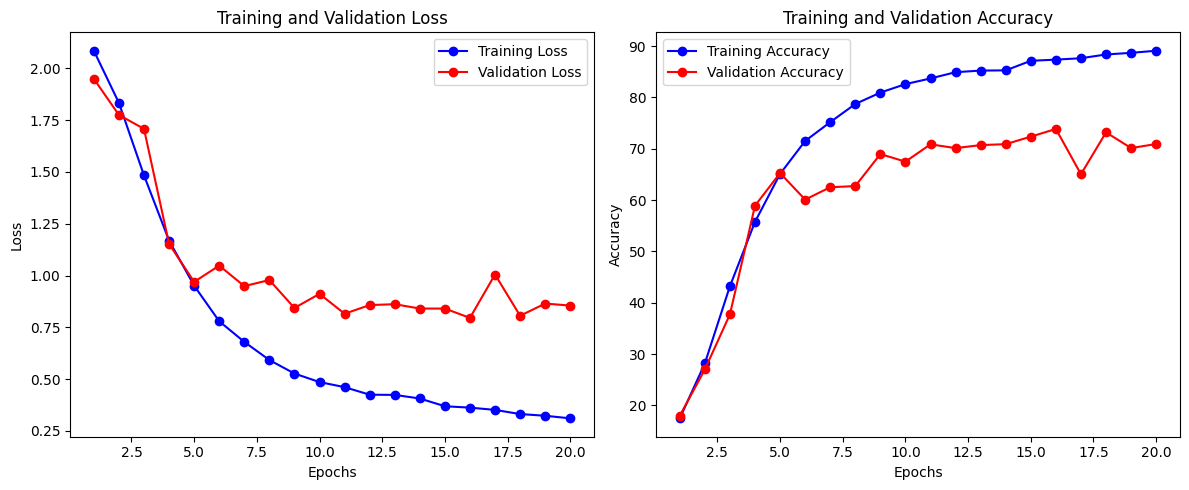

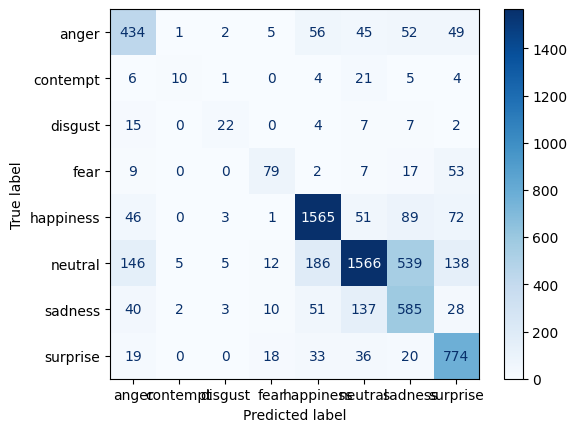

In [37]:

tiny_vgg = TinyVGG3(num_classes=num_classes)
optimizer = optim.Adam(tiny_vgg.parameters(), lr=learning_rate,weight_decay=wd)


train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(tiny_vgg,train_loader, test_loader,criterion, optimizer, num_epochs)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels)


3 convolutioanl block model 

The performance of the model agaisnt the validation set can be described as logarithmic, with clear improvements to loss stopping at around epoch 5. Past those epochs, loss and accuracy fluctuates hard, before stabilizing again at epoch 11. There is another sharp drop to the performance of both loss and accuracy at epoch 17. While training loss and accuracy maintained a consistant logarithmic gain across all 20 epochs. 

In [8]:
# implementing the tiny VGG with 4 convolutional layer blocks 
class TinyVGG4(nn.Module):
    def __init__(self, num_classes=8):
        super(TinyVGG4, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 1.9669, train Acc: 21.37%, validation Loss: 1.8815, validation Acc: 14.86%
Epoch 2/20, train Loss: 1.7100, train Acc: 32.16%, validation Loss: 1.7327, validation Acc: 21.28%
Epoch 3/20, train Loss: 1.3815, train Acc: 46.68%, validation Loss: 1.2622, validation Acc: 49.04%
Epoch 4/20, train Loss: 0.9885, train Acc: 62.45%, validation Loss: 1.1392, validation Acc: 57.39%
Epoch 5/20, train Loss: 0.7661, train Acc: 71.73%, validation Loss: 1.0034, validation Acc: 62.66%
Epoch 6/20, train Loss: 0.6301, train Acc: 77.09%, validation Loss: 0.9429, validation Acc: 66.92%
Epoch 7/20, train Loss: 0.5387, train Acc: 80.74%, validation Loss: 0.9124, validation Acc: 69.66%
Epoch 8/20, train Loss: 0.4797, train Acc: 82.87%, validation Loss: 0.8988, validation Acc: 68.53%
Epoch 9/20, train Loss: 0.4325, train Acc: 85.02%, validation Loss: 0.9092, validation Acc: 69.95%
Epoch 10/20, train Loss: 0.4021, train Acc: 85.93%, validation Loss: 0.8482, validation Acc: 71.91%
Epoch 11/

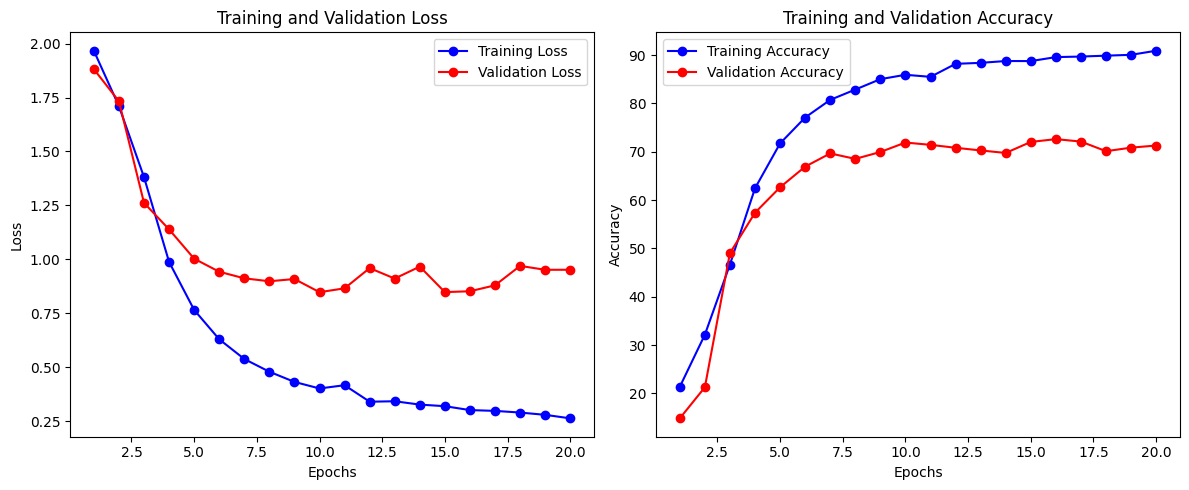

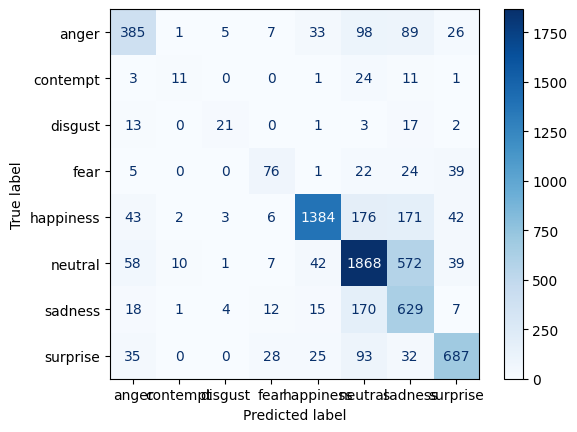

In [39]:
# Define loss function and optimizer
tiny_vgg_4block = TinyVGG4()
optimizer_4block = optim.Adam(tiny_vgg_4block.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_4block, val_losses_4block, train_accuracies_4block, val_accuracies_4block, all_preds_4block, all_labels_4block = train_model(tiny_vgg_4block,train_loader, test_loader,criterion, optimizer_4block, num_epochs)

plot_results(train_losses_4block, val_losses_4block, train_accuracies_4block, val_accuracies_4block, num_epochs, all_preds_4block, all_labels_4block)



4 convolutional block model

The performance of the model can be described as logarithmic, with clear improvements to loss stopping at around epoch 6 and at epoch 7 for accuracy. Past those epochs, loss flucuates between 0.96 and 0.94, and accuracy hovered at around 70%(+-2%), while training loss and accuracy kept improving. The performaced of the model was the best at epoch 16 (0.825 loss and 72.62% acc)

In [40]:
# adding another convolutional layer block (total of 5 blocks)

class TinyVGG5(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG5, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4

            # Convolutional Layer Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4 -> 2
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 2.0850, train Acc: 14.72%, validation Loss: 2.0997, validation Acc: 1.69%
Epoch 2/20, train Loss: 2.0699, train Acc: 15.04%, validation Loss: 2.1009, validation Acc: 2.70%
Epoch 3/20, train Loss: 2.0639, train Acc: 15.72%, validation Loss: 2.0690, validation Acc: 12.85%
Epoch 4/20, train Loss: 1.9447, train Acc: 22.87%, validation Loss: 1.9015, validation Acc: 23.72%
Epoch 5/20, train Loss: 1.6651, train Acc: 35.64%, validation Loss: 1.7292, validation Acc: 27.05%
Epoch 6/20, train Loss: 1.3050, train Acc: 50.39%, validation Loss: 1.5163, validation Acc: 39.13%
Epoch 7/20, train Loss: 1.1140, train Acc: 57.73%, validation Loss: 1.3986, validation Acc: 44.12%
Epoch 8/20, train Loss: 0.9884, train Acc: 62.25%, validation Loss: 1.3864, validation Acc: 43.88%
Epoch 9/20, train Loss: 0.9181, train Acc: 65.12%, validation Loss: 1.4329, validation Acc: 49.81%
Epoch 10/20, train Loss: 0.8536, train Acc: 67.96%, validation Loss: 1.2853, validation Acc: 50.64%
Epoch 11/20

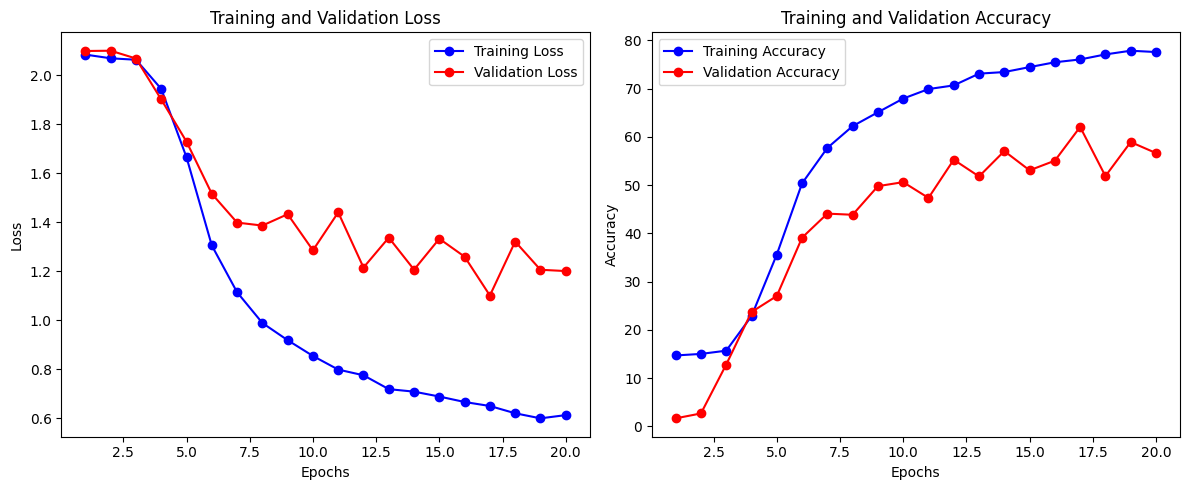

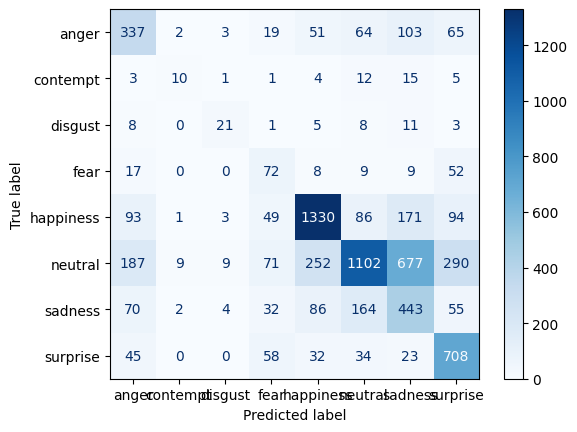

In [41]:

vgg_5block = TinyVGG5(num_classes=num_classes)
optimizer_5block = optim.Adam(vgg_5block.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_5block, val_losses_5block, train_accuracies_5block, val_accuracies_5block, all_preds_5block, all_labels_5block = train_model(vgg_5block,train_loader, test_loader,criterion, optimizer_5block, num_epochs)

plot_results(train_losses_5block, val_losses_5block, train_accuracies_5block, val_accuracies_5block, num_epochs, all_preds_5block, all_labels_5block)

5 convolutional block model

unlike the previous 2 modles, improvements in the first 3 epochs are low, then accelerating into large improvements(epochs 3 -8). Past epoch 8, large fluctuations can be seen, likely due to the model failing to converge. This cane be due to a multitude of reasons, over fitting, model being too complex for the given task or improper hyper-parameters.

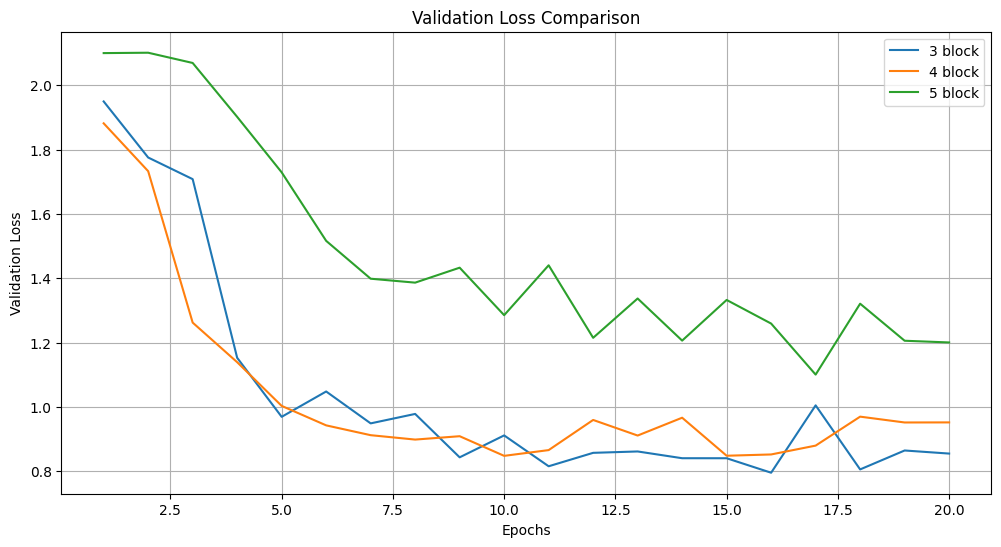

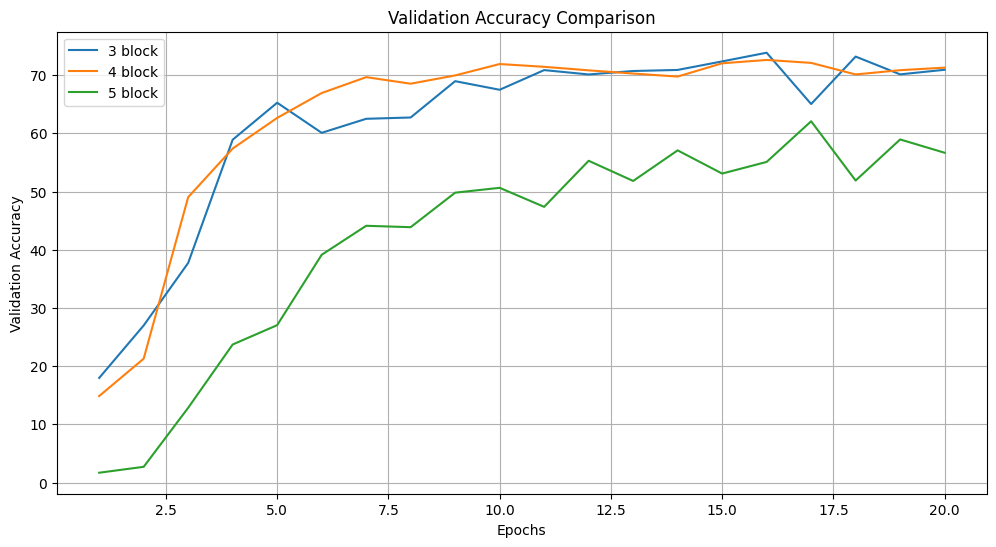

In [42]:
# comparing the validation loss and accuracy of the three models

epochs = range(1, num_epochs + 1)

# validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_losses, label='3 block')
plt.plot(epochs, val_losses_4block, label='4 block')
plt.plot(epochs, val_losses_5block, label='5 block')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies, label='3 block')
plt.plot(epochs, val_accuracies_4block, label='4 block')
plt.plot(epochs, val_accuracies_5block, label='5 block')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

Model comparison

The model with 5 convolutional layer blocked performed worse than both the 3 and 4 block models by around 14% at the end of the 20th epoch. While both the 3 and 4 block model performed similarly, the performance of the 4 block model was noticably more stable with less flunctuations between epcohs. However, across all epochs, the 3 block has achieved the highest accurcy at 73.86%(epoch 16), 1.24% higher than the 4 block model's highest at 72.62%(also epoch 16)

Based on the above findings, I find the model with 4 convolutional layer blocks to be the most suitable for this task. Hence, hyper-parameter tuning will be performed with the 4 block model

In [12]:
# hyper parameter tuning
from sklearn.model_selection import ParameterGrid

#base params:
#   lr = 0.001
#   batch = 32
#   optimizer  = adam
#   wd = 0.001

param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['SGD', 'Adam'],
    'weight_decay': [0.0001, 0.001, 0.01]
}

best_params = None
best_val_accuracy = 0

for params in ParameterGrid(param_grid):
    print(params)
    # Initialize the model, criterion, and optimizer with the current hyperparameters
    model = TinyVGG4(num_classes=8)
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
    # Update data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Train the model
    _, _, _, val_accuracies, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

    # Get the best validation accuracy for the current hyperparameters
    max_val_accuracy = max(val_accuracies)
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Validation Accuracy: {best_val_accuracy}')

{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.0001}
Epoch 1/15, train Loss: 1.4521, train Acc: 45.65%, validation Loss: 2.4700, validation Acc: 28.03%
Epoch 2/15, train Loss: 0.7885, train Acc: 71.01%, validation Loss: 5.1746, validation Acc: 14.86%
Epoch 3/15, train Loss: 0.5742, train Acc: 79.16%, validation Loss: 1.7835, validation Acc: 38.50%
Epoch 4/15, train Loss: 0.4529, train Acc: 83.62%, validation Loss: 2.4447, validation Acc: 40.30%
Epoch 5/15, train Loss: 0.3731, train Acc: 86.44%, validation Loss: 0.9153, validation Acc: 70.73%
Epoch 6/15, train Loss: 0.3174, train Acc: 88.44%, validation Loss: 0.9129, validation Acc: 70.04%
Epoch 7/15, train Loss: 0.2696, train Acc: 90.58%, validation Loss: 29.1496, validation Acc: 2.41%
Epoch 8/15, train Loss: 0.3026, train Acc: 89.91%, validation Loss: 0.8445, validation Acc: 73.46%
Epoch 9/15, train Loss: 0.1950, train Acc: 93.14%, validation Loss: 2.2471, validation Acc: 65.50%
Epoch 10/15, train Loss: 0.1952, t

Sorting all hyper-parameter combinations into 6 categories

high fluctuations and bad <60%  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.001}  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.01}  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.01}  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.001}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 0.01}  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.01}  

high fluctuations and bad <70%  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.001}  

likely will benefit from more epochs  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.01}  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'SGD', 'weight_decay': 0.01}  

high fluctuations but good highs >72%  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.001}  
{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.01}  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.01}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.01}  

low fluctuations but not great <70%  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.01}  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.001}  

low fluctuations and good >70%  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.001}  
{'batch_size': 64, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.001}  
{'batch_size': 32, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.0001}  
{'batch_size': 32, 'lr': 0.0001, 'optimizer': 'Adam', 'weight_decay': 0.001}  

Observations:

while the model with these parameters {'batch_size': 64, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.01} gave the highest accuracy, its perforamance between epochs fluctuates greatly.

Instaed the model with parameters:
{'batch_size': 64, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 0.001}, seems to have more potential. with accuracy increasing till the end of all 15 epochs.

Epoch 1/30, train Loss: 2.0454, train Acc: 19.06%, validation Loss: 1.9429, validation Acc: 11.35%
Epoch 2/30, train Loss: 1.5865, train Acc: 38.23%, validation Loss: 1.4800, validation Acc: 41.22%
Epoch 3/30, train Loss: 1.1439, train Acc: 56.71%, validation Loss: 1.2804, validation Acc: 45.72%
Epoch 4/30, train Loss: 0.8817, train Acc: 66.75%, validation Loss: 1.5954, validation Acc: 38.64%
Epoch 5/30, train Loss: 0.7270, train Acc: 73.08%, validation Loss: 0.9388, validation Acc: 64.40%
Epoch 6/30, train Loss: 0.6122, train Acc: 78.11%, validation Loss: 1.2080, validation Acc: 51.54%
Epoch 7/30, train Loss: 0.5426, train Acc: 80.89%, validation Loss: 1.0789, validation Acc: 58.83%
Epoch 8/30, train Loss: 0.4662, train Acc: 83.90%, validation Loss: 1.0597, validation Acc: 61.05%
Epoch 9/30, train Loss: 0.4248, train Acc: 85.44%, validation Loss: 0.9137, validation Acc: 69.78%
Epoch 10/30, train Loss: 0.3826, train Acc: 86.80%, validation Loss: 1.1313, validation Acc: 64.35%
Epoch 11/

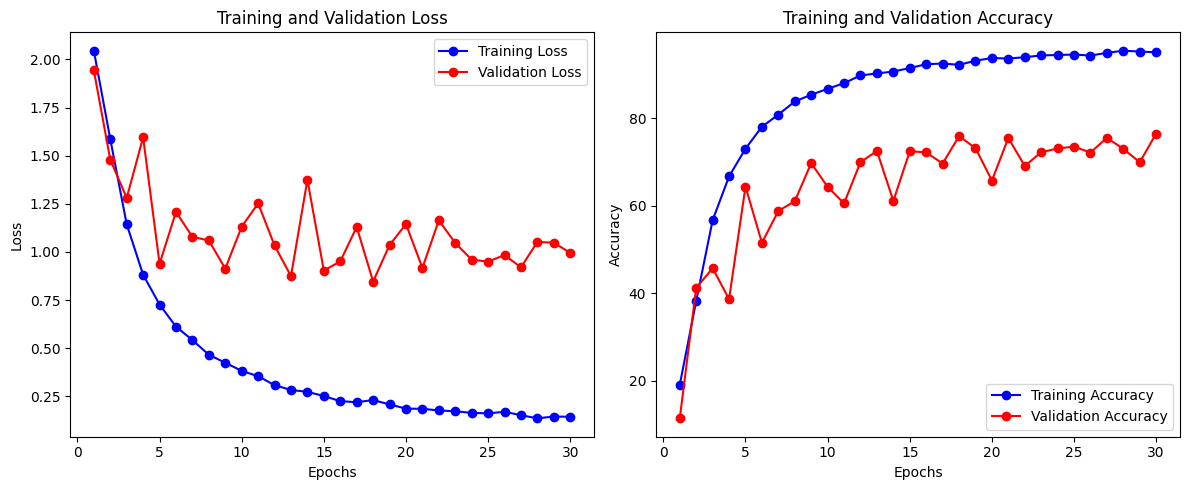

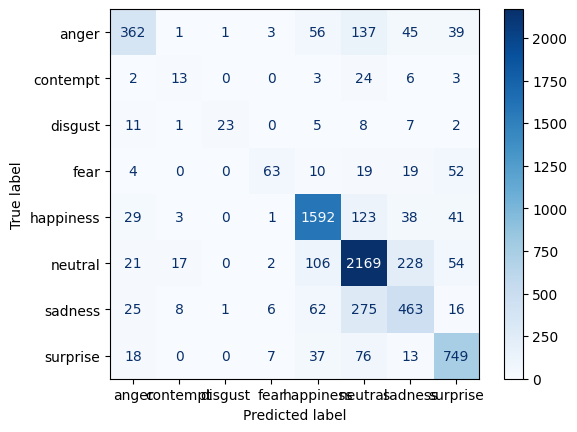

In [13]:
# we further increase that batch size to 128, as there is noticable performance gains across all models with the increase of batch size from 32 -> 64
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
wd = 0.001
num_epochs = 30

model_tuned = TinyVGG4(num_classes=8)

optimizer_tuned = optim.Adam(model_tuned.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_tuned, val_losses_tuned, train_accuracies_tuned, val_accuracies_tuned, all_preds_tuned, all_labels_tuned = train_model(model_tuned,train_loader, test_loader,criterion, optimizer_tuned, num_epochs)

plot_results(train_losses_tuned, val_losses_tuned, train_accuracies_tuned, val_accuracies_tuned, num_epochs, all_preds_tuned, all_labels_tuned)



Epoch 1/30, train Loss: 1.9319, train Acc: 24.23%, validation Loss: 1.8265, validation Acc: 14.38%
Epoch 2/30, train Loss: 1.5269, train Acc: 40.28%, validation Loss: 1.7115, validation Acc: 29.06%
Epoch 3/30, train Loss: 1.2045, train Acc: 54.65%, validation Loss: 1.2810, validation Acc: 50.53%
Epoch 4/30, train Loss: 0.9248, train Acc: 65.24%, validation Loss: 1.1304, validation Acc: 58.64%
Epoch 5/30, train Loss: 0.7456, train Acc: 72.57%, validation Loss: 1.0678, validation Acc: 55.64%
Epoch 6/30, train Loss: 0.6267, train Acc: 77.45%, validation Loss: 1.0658, validation Acc: 61.64%
Epoch 7/30, train Loss: 0.5285, train Acc: 81.26%, validation Loss: 0.9692, validation Acc: 67.11%
Epoch 8/30, train Loss: 0.4587, train Acc: 83.97%, validation Loss: 0.8752, validation Acc: 70.74%
Epoch 9/30, train Loss: 0.4083, train Acc: 85.83%, validation Loss: 0.9156, validation Acc: 69.93%
Epoch 10/30, train Loss: 0.3756, train Acc: 87.14%, validation Loss: 1.2594, validation Acc: 60.21%
Epoch 11/

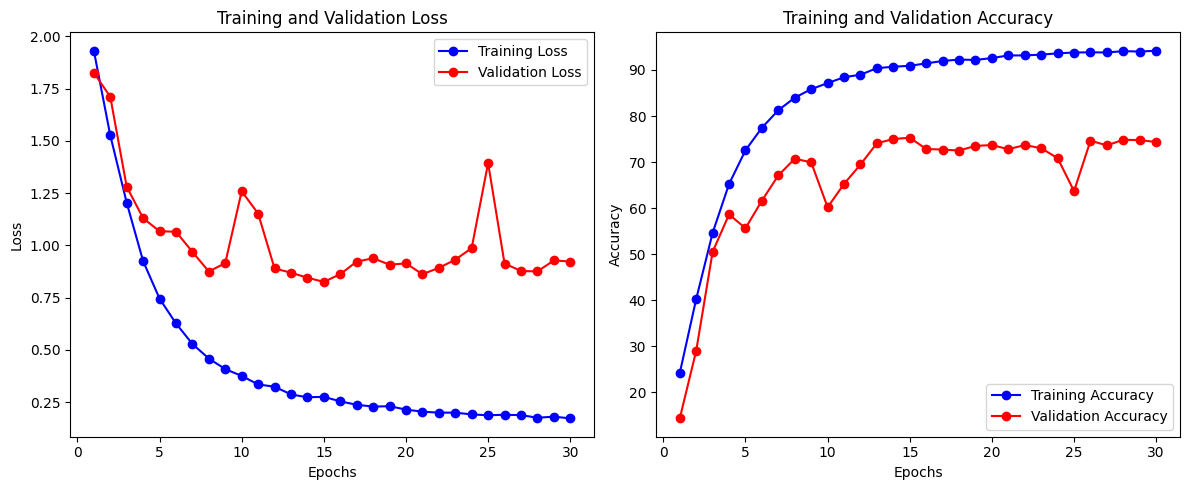

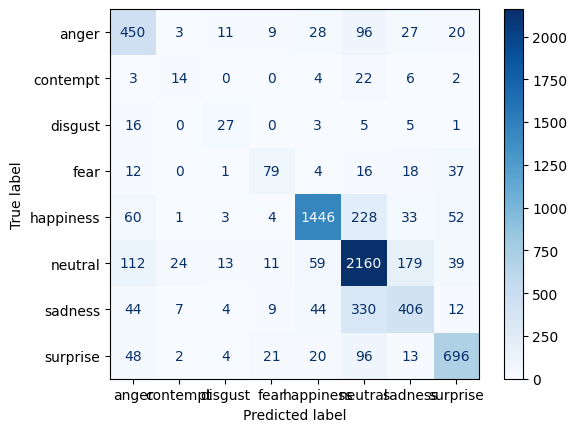

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
wd = 0.001
num_epochs = 30

model_tuned_64 = TinyVGG4(num_classes=8)

optimizer_tuned_64 = optim.Adam(model_tuned_64.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_tuned_64, val_losses_tuned_64, train_accuracies_tuned_64, val_accuracies_tuned_64, all_preds_tuned_64, all_labels_tuned_64 = train_model(model_tuned_64,train_loader, test_loader,criterion, optimizer_tuned_64, num_epochs)

plot_results(train_losses_tuned_64, val_losses_tuned_64, train_accuracies_tuned_64, val_accuracies_tuned_64, num_epochs, all_preds_tuned_64, all_labels_tuned_64)

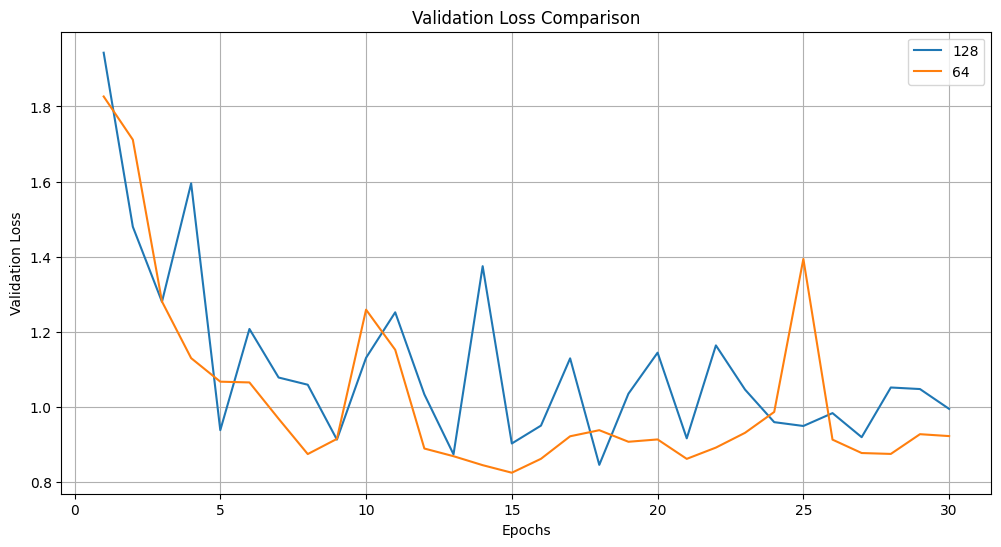

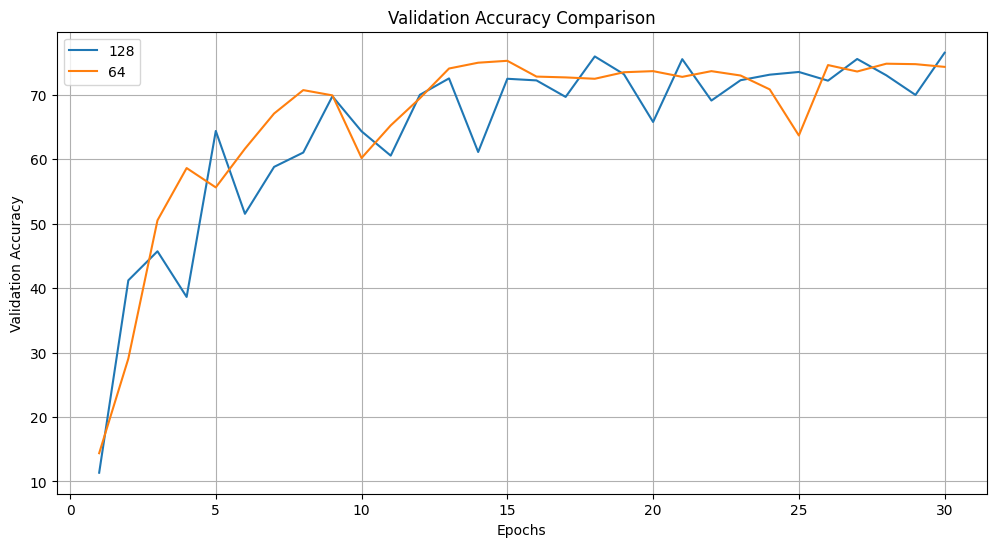

In [15]:
# comparing previously tuned models
epochs = range(1, num_epochs + 1)

# validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_losses_tuned, label='128')
plt.plot(epochs, val_losses_tuned_64, label='64')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies_tuned, label='128')
plt.plot(epochs, val_accuracies_tuned_64, label='64')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# save the models
torch.save(model_tuned, '4block_128batch.pth')
torch.save(model_tuned_64,'4block_64batch.pth')

Image: Screenshot 2024-08-03 162822.png, Predicted: happiness


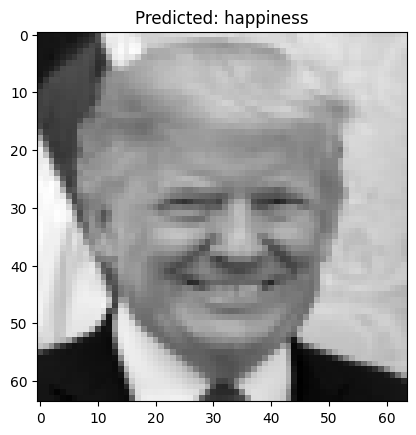

Image: Screenshot 2024-08-03 163041.png, Predicted: anger


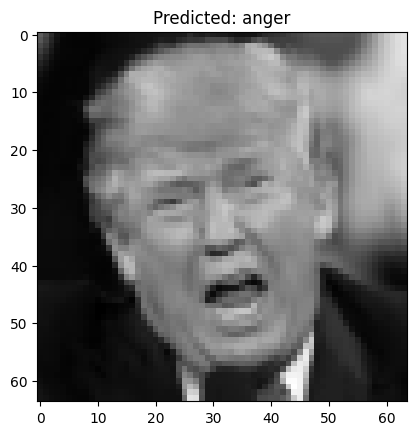

Image: Screenshot 2024-08-03 163457.png, Predicted: neutral


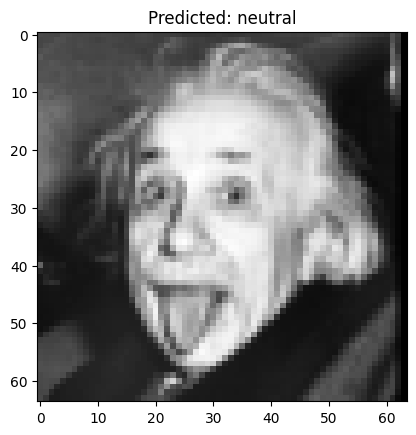

Image: Screenshot 2024-08-03 163548.png, Predicted: neutral


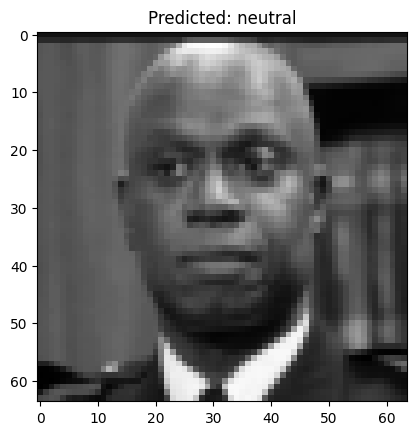

In [34]:
import os 
from PIL import Image

#loading model and testing

model = torch.load('4block_64batch.pth')
model.eval()

test_folder = './custom_test'

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

for image_name in os.listdir(test_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image extensions
        image_path = os.path.join(test_folder, image_name)
        image = Image.open(image_path)

        # Apply transformations to the image
        input_tensor = transform(image)
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
        input_tensor = input_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = classes[predicted[0]]

        # Display the image and the predicted label
        print(f'Image: {image_name}, Predicted: {predicted_label}')
        imshow(torch.Tensor.cpu(input_tensor[0]), title=f'Predicted: {predicted_label}')
        plt.show()